# Battle of the Neighbohoods
Final datascience capstone project from IBM course

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


## 1. Getting databases of neighborhoods for each city with geolocalisation

In [2]:
# Download 3 files for the 3 cities
!wget -q -O 'quartiers_bordeaux.xlsx' https://raw.githubusercontent.com/Gascon-data/Coursera_Capstone/master/Quartiers_Bordeaux.xlsx
!wget -q -O 'quartiers_paris.csv' https://raw.githubusercontent.com/Gascon-data/Coursera_Capstone/master/quartier_paris.csv
!wget -q -O 'quartiers_toulouse.csv' https://raw.githubusercontent.com/Gascon-data/Coursera_Capstone/master/population-2016-grands-quartiers-Toulouse.csv
print('Data downloaded!')

Data downloaded!


In [3]:
#Import data for Paris into a dataframe
df_qp=pd.read_csv('quartiers_paris.csv', sep=';')
df_qp=pd.DataFrame(df_qp)
print('There are {} neighborhoods in Paris'.format(df_qp.shape[0]))
df_qp.head()

There are 80 neighborhoods in Paris


,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000032,32,7510804,Europe,8,750000008,4803.242769,1.182467e+06,"48.8781476759,2.3171746113","{""type"": ""Polygon"", ""coordinates"": [[[2.312293..."
1,750000044,44,7511104,Sainte-Marguerite,11,750000011,4591.310799,9.296092e+05,"48.852096507,2.3887648336","{""type"": ""Polygon"", ""coordinates"": [[[2.396236..."
2,750000054,54,7511402,Parc-de-Montsouris,14,750000014,5224.265369,1.357950e+06,"48.8234527716,2.33707017986","{""type"": ""Polygon"", ""coordinates"": [[[2.343996..."
3,750000057,57,7511501,Saint-Lambert,15,750000015,6928.792072,2.829202e+06,"48.8342936284,2.29691997445","{""type"": ""Polygon"", ""coordinates"": [[[2.304248..."
4,750000048,48,7511204,Quinze-Vingts,12,750000012,4509.486974,1.235916e+06,"48.8469159441,2.37440162648","{""type"": ""Polygon"", ""coordinates"": [[[2.373204..."


In [4]:
#Keep only the interesting columns & split the 'Geometry X Y' column into 2 columns: Latitude & Longitude
df_qp=df_qp[['L_QU', 'Geometry X Y','C_AR']]
df_qp[['Latitude','Longitude']]=df_qp['Geometry X Y'].str.split(',',expand=True)
df_qp.drop('Geometry X Y', axis=1,inplace=True)
df_qp.rename(columns={'L_QU':'Quartier'},inplace=True)
df_qp.rename(columns={'C_AR':'arrondissement'},inplace=True)
df_qp['City']='Paris'
df_qp.head()

,Quartier,arrondissement,Latitude,Longitude,City
0,Europe,8,48.8781476759,2.3171746113,Paris
1,Sainte-Marguerite,11,48.852096507,2.3887648336,Paris
2,Parc-de-Montsouris,14,48.8234527716,2.33707017986,Paris
3,Saint-Lambert,15,48.8342936284,2.29691997445,Paris
4,Quinze-Vingts,12,48.8469159441,2.37440162648,Paris


In [5]:
#Import data for Toulouse into a dataframe
df_qt=pd.read_csv('quartiers_toulouse.csv', sep=';')
df_qt=pd.DataFrame(df_qt)
print('There are {} neighborhoods in Toulouse'.format(df_qt.shape[0]))
df_qt.head()

There are 60 neighborhoods in Toulouse


,Geo Point,Geo Shape,GRD_QUART,Libelle des grands quartiers,REG2016,DEP,UU2010,CODE_INSEE,P16_POP0205,P16_POP0610,P16_POP1114,P16_POP1517,P16_POP1824,P16_POP2529,P16_POP30P,P16_SCOL0205,P16_SCOL0610,P16_SCOL1114,P16_SCOL1517,P16_SCOL1824,P16_SCOL2529,P16_SCOL30P,P16_NSCOL15P,P16_NSCOL15P_DIPLMIN,P16_NSCOL15P_CAPBEP,P16_NSCOL15P_BAC,P16_NSCOL15P_SUP,P16_HNSCOL15P,P16_HNSCOL15P_DIPLMIN,P16_HNSCOL15P_CAPBEP,P16_HNSCOL15P_BAC,P16_HNSCOL15P_SUP,P16_FNSCOL15P,P16_FNSCOL15P_DIPLMIN,P16_FNSCOL15P_CAPBEP,P16_FNSCOL15P_BAC,P16_FNSCOL15P_SUP
0,"43.596087197,1.44140164967","{""type"": ""Polygon"", ""coordinates"": [[[1.444207...",3155505,CARMES,76,31,31701,31555,157.084863,136.470186,134.609880,96.984641,1667.193821,1050.358543,2922.771161,129.203253,129.058278,133.621576,96.984641,1400.419179,268.236041,65.881501,3905.786804,337.938989,238.986803,507.534249,2821.326762,1930.301581,91.016899,147.557708,250.272711,1441.454262,1975.485223,246.922090,91.429095,257.261538,1379.872500
1,"43.6062858201,1.42339702287","{""type"": ""Polygon"", ""coordinates"": [[[1.434335...",3155507,AMIDONNIERS,76,31,31701,31555,160.069427,189.362370,145.560226,144.482911,2311.551558,919.168453,3196.494092,96.856469,189.362370,145.560226,144.482911,2083.029069,218.792768,56.964836,4068.427431,329.054465,309.973211,503.212499,2926.187255,2060.439942,135.012938,170.401013,231.756993,1523.268998,2007.987488,194.041527,139.572198,271.455506,1402.918257
2,"43.6191621779,1.43195460628","{""type"": ""Polygon"", ""coordinates"": [[[1.420383...",3155518,MINIMES,76,31,31701,31555,1097.269913,1265.467568,812.646504,714.029987,3601.869498,3001.335939,14678.995372,751.055242,1218.594682,807.972354,686.157197,2357.901195,419.251916,290.826219,18242.094268,3416.707827,2549.417655,2946.571832,9329.396953,8834.918866,1471.010835,1368.352507,1435.704392,4559.851132,9407.175402,1945.696992,1181.065148,1510.867441,4769.545821
3,"43.6195659969,1.45452253663","{""type"": ""Polygon"", ""coordinates"": [[[1.461863...",3155519,BONNEFOY,76,31,31701,31555,406.228210,394.824933,282.319917,237.317328,1028.518870,930.985343,5298.759685,280.705259,380.026874,281.311094,229.765564,660.361074,145.649448,131.501540,6328.303599,1244.983661,1090.197435,1104.671100,2888.451404,2992.995532,469.073980,633.668666,500.740214,1389.512672,3335.308067,775.909681,456.528768,603.930886,1498.938732
4,"43.6117583769,1.46190401897","{""type"": ""Polygon"", ""coordinates"": [[[1.470790...",3155520,MARENGO - JOLIMONT,76,31,31701,31555,300.138633,426.040435,284.495979,330.051360,2611.976544,1435.482031,6401.488649,205.158091,422.243425,284.495979,317.852998,1841.279465,243.110035,192.439434,8184.316652,1324.836428,1037.329631,1358.465556,4463.685037,3979.741548,582.736207,567.008842,658.928719,2171.067780,4204.575104,742.100221,470.320789,699.536837,2292.617257


In [6]:
#This database is about population categories but we are not interested in this data, so we are going to drop those columns.
#We will also split the 'Geo Point' column into 2 columns: Latitude & Longitude
df_qt = df_qt[['Geo Point', 'Libelle des grands quartiers']]
df_qt.rename(columns={'Libelle des grands quartiers':'Quartier'}, inplace=True)
df_qt[['Latitude','Longitude']]=df_qt['Geo Point'].str.split(',',expand=True)
df_qt.drop('Geo Point', axis=1,inplace=True)
df_qt['City']='Toulouse'
df_qt['arrondissement']='Toulouse'
df_qt.head()

,Quartier,Latitude,Longitude,City,arrondissement
0,CARMES,43.596087197,1.44140164967,Toulouse,Toulouse
1,AMIDONNIERS,43.6062858201,1.42339702287,Toulouse,Toulouse
2,MINIMES,43.6191621779,1.43195460628,Toulouse,Toulouse
3,BONNEFOY,43.6195659969,1.45452253663,Toulouse,Toulouse
4,MARENGO - JOLIMONT,43.6117583769,1.46190401897,Toulouse,Toulouse


In [7]:
#Import data for Bordeaux into a dataframe
df_qb=pd.read_excel('quartiers_bordeaux.xlsx')
df_qb=pd.DataFrame(df_qb)
print('There are {} neighborhoods in Bordeaux'.format(df_qb.shape[0]))
df_qb.head()

There are 14 neighborhoods in Bordeaux


,Unnamed: 0,Quartier,Latitude,Longitude
0,NaN,Caudéran,44.852678,-0.614895
1,NaN,Barrière Judaïque,44.840425,-0.600305
2,NaN,Grand Parc - Chartrons - Paul Doumer,44.860527,-0.566944
3,NaN,Capucins - Victoire,44.831345,-0.567414
4,NaN,Nansouty,44.819515,-0.572298


In [8]:
df_qb.drop('Unnamed: 0', axis=1, inplace=True)
df_qb['City']='Bordeaux'
df_qb['arrondissement']='Bordeaux'
df_qb.head()

,Quartier,Latitude,Longitude,City,arrondissement
0,Caudéran,44.852678,-0.614895,Bordeaux,Bordeaux
1,Barrière Judaïque,44.840425,-0.600305,Bordeaux,Bordeaux
2,Grand Parc - Chartrons - Paul Doumer,44.860527,-0.566944,Bordeaux,Bordeaux
3,Capucins - Victoire,44.831345,-0.567414,Bordeaux,Bordeaux
4,Nansouty,44.819515,-0.572298,Bordeaux,Bordeaux


In [9]:
#Merge the 3 dataframes
df_quartiers = pd.concat([df_qt, df_qb,df_qp],axis=0)
df_quartiers.reset_index(drop=True,inplace=True)
df_quartiers[df_quartiers['City']== 'Toulouse']['arrondissement']=df_quartiers['City']
print('Total number of neighborhood: {}'.format(df_quartiers.shape[0]))
df_quartiers.head(5)

Total number of neighborhood: 154


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Quartier,Latitude,Longitude,City,arrondissement
0,CARMES,43.596087197,1.44140164967,Toulouse,Toulouse
1,AMIDONNIERS,43.6062858201,1.42339702287,Toulouse,Toulouse
2,MINIMES,43.6191621779,1.43195460628,Toulouse,Toulouse
3,BONNEFOY,43.6195659969,1.45452253663,Toulouse,Toulouse
4,MARENGO - JOLIMONT,43.6117583769,1.46190401897,Toulouse,Toulouse


## 2. Gathering real estate prices for the 3 cities

In [10]:
# Download 3 files with all transactions for 2019
!wget -q -O '31.csv' https://raw.githubusercontent.com/Gascon-data/Coursera_Capstone/master/31.csv/31.csv
!wget -q -O '33.csv' https://raw.githubusercontent.com/Gascon-data/Coursera_Capstone/master/33.csv/33.csv
!wget -q -O '75.csv' https://raw.githubusercontent.com/Gascon-data/Coursera_Capstone/master/75.csv/75.csv
print('Data downloaded!')

Data downloaded!


In [11]:
#Get data from 31.csv into a dataframe
toulouse_data = pd.read_csv('31.csv')
toulouse_data = pd.DataFrame(toulouse_data)
toulouse_data.head(10)

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2019-249029,2019-01-05,1,Vente,255300.0,15.0,NaN,RUE D'AUBUISSON,0608,31000.0,31555,Toulouse,31,NaN,NaN,31555821AC0319,NaN,NaN,3.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,49.0,1.0,NaN,NaN,NaN,NaN,NaN,1.452922,43.602994
1,2019-249030,2019-01-03,1,Vente,380000.0,12.0,NaN,RUE SAINT LIGORY,7888,31500.0,31555,Toulouse,31,NaN,NaN,31555807AB0581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,52.0,2.0,S,sols,NaN,NaN,160.0,1.461426,43.602333
2,2019-249031,2019-01-07,1,Vente,128000.0,13.0,NaN,RUE DES PAQUERETTES,6516,31500.0,31555,Toulouse,31,NaN,NaN,31555805AD0042,NaN,NaN,164.0,78.32,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,78.0,5.0,NaN,NaN,NaN,NaN,NaN,1.464352,43.622709
3,2019-249032,2019-01-04,1,Vente,200000.0,26.0,NaN,PL DES CYTISES,0190,31240.0,31488,Saint-Jean,31,NaN,NaN,31488000AC0148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,S,sols,NaN,NaN,16.0,1.500943,43.672144
4,2019-249032,2019-01-04,1,Vente,200000.0,26.0,NaN,PL DES CYTISES,0190,31240.0,31488,Saint-Jean,31,NaN,NaN,31488000AC0150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,92.0,5.0,S,sols,NaN,NaN,178.0,1.500838,43.672047
5,2019-249033,2019-01-02,1,Vente,270000.0,NaN,NaN,AV SAINT MARTIN DE BOVILLE,0815,31130.0,31044,Balma,31,NaN,NaN,31044000BN0258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,S,sols,NaN,NaN,612.0,1.504465,43.597264
6,2019-249034,2019-01-09,1,Vente,155447.0,22.0,NaN,RUE DES GENETS,3824,31500.0,31555,Toulouse,31,NaN,NaN,31555834AT0177,NaN,NaN,146.0,84.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,78.0,4.0,NaN,NaN,NaN,NaN,NaN,1.469987,43.610579
7,2019-249034,2019-01-09,1,Vente,155447.0,22.0,NaN,RUE DES GENETS,3824,31500.0,31555,Toulouse,31,NaN,NaN,31555834AT0177,NaN,NaN,446.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.469987,43.610579
8,2019-249035,2019-01-07,1,Vente,245000.0,NaN,NaN,RUE CLAUDE GONIN,2108,31400.0,31555,Toulouse,31,NaN,NaN,31555837AK0445,NaN,NaN,1103.0,79.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4.0,Local industriel. commercial ou assimilé,118.0,0.0,NaN,NaN,NaN,NaN,NaN,1.483988,43.573572
9,2019-249035,2019-01-07,1,Vente,245000.0,5.0,NaN,RUE CLAUDE GONIN,2108,31400.0,31555,Toulouse,31,NaN,NaN,31555837AK0445,NaN,NaN,1084.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.483988,43.573572


In [12]:
#Keep only the relevant columns from our dataframe
df_toulouse = toulouse_data[['id_mutation', 'date_mutation', 'valeur_fonciere', 'code_postal','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','surface_terrain','longitude', 'latitude']]
df_toulouse.head(10)

,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2019-249029,2019-01-05,255300.0,31000.0,Toulouse,Appartement,49.0,1.0,NaN,1.452922,43.602994
1,2019-249030,2019-01-03,380000.0,31500.0,Toulouse,Maison,52.0,2.0,160.0,1.461426,43.602333
2,2019-249031,2019-01-07,128000.0,31500.0,Toulouse,Appartement,78.0,5.0,NaN,1.464352,43.622709
3,2019-249032,2019-01-04,200000.0,31240.0,Saint-Jean,NaN,NaN,NaN,16.0,1.500943,43.672144
4,2019-249032,2019-01-04,200000.0,31240.0,Saint-Jean,Maison,92.0,5.0,178.0,1.500838,43.672047
5,2019-249033,2019-01-02,270000.0,31130.0,Balma,NaN,NaN,NaN,612.0,1.504465,43.597264
6,2019-249034,2019-01-09,155447.0,31500.0,Toulouse,Appartement,78.0,4.0,NaN,1.469987,43.610579
7,2019-249034,2019-01-09,155447.0,31500.0,Toulouse,Dépendance,NaN,0.0,NaN,1.469987,43.610579
8,2019-249035,2019-01-07,245000.0,31400.0,Toulouse,Local industriel. commercial ou assimilé,118.0,0.0,NaN,1.483988,43.573572
9,2019-249035,2019-01-07,245000.0,31400.0,Toulouse,Dépendance,NaN,0.0,NaN,1.483988,43.573572


In [13]:
#Filter to keep only transactions concerning houses & flats in Toulouse city
df_toulouse = df_toulouse[df_toulouse['nom_commune']=='Toulouse']
df_toulouse = df_toulouse[(df_toulouse['type_local']=='Appartement')|(df_toulouse['type_local']=='Maison')]
df_toulouse['arrondissement']='Toulouse'

print('There have been {} transactions in Toulouse in 2019'.format(df_toulouse.shape[0]))
df_toulouse.head(10)

There have been 7236 transactions in Toulouse in 2019


,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement
0,2019-249029,2019-01-05,255300.0,31000.0,Toulouse,Appartement,49.0,1.0,NaN,1.452922,43.602994,Toulouse
1,2019-249030,2019-01-03,380000.0,31500.0,Toulouse,Maison,52.0,2.0,160.0,1.461426,43.602333,Toulouse
2,2019-249031,2019-01-07,128000.0,31500.0,Toulouse,Appartement,78.0,5.0,NaN,1.464352,43.622709,Toulouse
6,2019-249034,2019-01-09,155447.0,31500.0,Toulouse,Appartement,78.0,4.0,NaN,1.469987,43.610579,Toulouse
10,2019-249036,2019-01-09,72000.0,31500.0,Toulouse,Appartement,39.0,2.0,NaN,1.467042,43.596685,Toulouse
11,2019-249037,2019-01-08,108500.0,31400.0,Toulouse,Appartement,45.0,2.0,NaN,1.460912,43.594870,Toulouse
15,2019-249041,2019-01-08,250000.0,31000.0,Toulouse,Appartement,50.0,2.0,NaN,1.450516,43.602107,Toulouse
20,2019-249044,2019-01-03,100728.0,31500.0,Toulouse,Appartement,63.0,3.0,NaN,1.464641,43.612744,Toulouse
22,2019-249046,2019-01-11,74000.0,31000.0,Toulouse,Appartement,18.0,1.0,NaN,1.428619,43.605316,Toulouse
25,2019-249047,2019-01-02,116800.0,31500.0,Toulouse,Appartement,56.0,3.0,NaN,1.457806,43.598195,Toulouse


In [14]:
#Perform same data wrangling on Bordeaux data
bordeaux_data = pd.read_csv('33.csv')
bordeaux_data = pd.DataFrame(bordeaux_data)

df_bordeaux = bordeaux_data[['id_mutation', 'date_mutation', 'valeur_fonciere', 'code_postal','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','surface_terrain','longitude', 'latitude']]

df_bordeaux = df_bordeaux[df_bordeaux['nom_commune']=='Bordeaux']
df_bordeaux = df_bordeaux[(df_bordeaux['type_local']=='Appartement')|(df_bordeaux['type_local']=='Maison')]
df_bordeaux['arrondissement']='Bordeaux'

print('There have been {} transactions in Bordeaux in 2019'.format(df_bordeaux.shape[0]))
df_bordeaux.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (14,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There have been 6182 transactions in Bordeaux in 2019


,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement
10,2019-274142,2019-01-09,80000.0,33000.0,Bordeaux,Appartement,16.0,1.0,NaN,-0.585259,44.847908,Bordeaux
28,2019-274149,2019-01-08,421000.0,33300.0,Bordeaux,Maison,136.0,6.0,337.0,-0.549133,44.878439,Bordeaux
30,2019-274150,2019-01-09,210000.0,33000.0,Bordeaux,Appartement,63.0,3.0,NaN,-0.598343,44.837126,Bordeaux
32,2019-274152,2019-01-07,447850.0,33300.0,Bordeaux,Appartement,77.0,3.0,NaN,-0.569430,44.853650,Bordeaux
33,2019-274153,2019-01-03,613000.0,33200.0,Bordeaux,Maison,90.0,4.0,180.0,-0.603308,44.846765,Bordeaux
41,2019-274157,2019-01-04,116000.0,33000.0,Bordeaux,Appartement,25.0,1.0,NaN,-0.580599,44.845479,Bordeaux
51,2019-274160,2019-01-09,320000.0,33000.0,Bordeaux,Appartement,80.0,3.0,NaN,-0.586461,44.838571,Bordeaux
57,2019-274163,2019-01-07,190000.0,33300.0,Bordeaux,Appartement,52.0,3.0,NaN,-0.549050,44.869849,Bordeaux
60,2019-274165,2019-01-08,280000.0,33300.0,Bordeaux,Appartement,73.0,4.0,NaN,-0.571012,44.862164,Bordeaux
69,2019-274170,2019-01-03,316500.0,33200.0,Bordeaux,Maison,84.0,4.0,286.0,-0.626925,44.845425,Bordeaux


In [15]:
#Perform same data wrangling on Paris data - without filter on the 'nom_commune' column as we want to keep all the "Arrondissements" of Paris
paris_data = pd.read_csv('75.csv')
paris_data = pd.DataFrame(paris_data)

df_paris = paris_data[['id_mutation', 'date_mutation', 'valeur_fonciere', 'code_postal','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','surface_terrain','longitude', 'latitude']]

df_paris = df_paris[(df_paris['type_local']=='Appartement')|(df_paris['type_local']=='Maison')]

print('There have been {} transactions in Paris in 2019'.format(df_paris.shape[0]))
df_paris.head(10)

There have been 36663 transactions in Paris in 2019


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,20,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2019-1062991,2019-01-04,1196000.0,75001.0,Paris 1er Arrondissement,Appartement,112.0,3.0,NaN,2.325288,48.868416
1,2019-1062992,2019-01-03,1570490.0,75003.0,Paris 3e Arrondissement,Appartement,104.0,3.0,NaN,2.363076,48.860305
4,2019-1062994,2019-01-03,5400.0,75003.0,Paris 3e Arrondissement,Appartement,21.0,1.0,NaN,2.353479,48.864674
5,2019-1062995,2019-01-10,230000.0,75003.0,Paris 3e Arrondissement,Appartement,26.0,1.0,NaN,2.354961,48.868615
7,2019-1062997,2019-01-05,955750.0,75008.0,Paris 8e Arrondissement,Appartement,80.0,3.0,NaN,2.314393,48.880118
8,2019-1062998,2019-01-07,506800.0,75003.0,Paris 3e Arrondissement,Appartement,45.0,2.0,NaN,2.362024,48.865675
9,2019-1062999,2019-01-07,565950.0,75008.0,Paris 8e Arrondissement,Appartement,55.0,3.0,NaN,2.317442,48.879965
11,2019-1063000,2019-01-09,582000.0,75003.0,Paris 3e Arrondissement,Appartement,41.0,2.0,NaN,2.366022,48.860861
12,2019-1063001,2019-01-09,200000.0,75008.0,Paris 8e Arrondissement,Appartement,28.0,1.0,NaN,2.305499,48.874098
13,2019-1063002,2019-01-08,2638500.0,75008.0,Paris 8e Arrondissement,Appartement,260.0,8.0,NaN,2.302062,48.878463


In [16]:
#Split the 'nom_commune' into 2 columns: 'Paris' & the arrondissement number
df_paris[['nom_commune','arrondissement']]=df_paris['nom_commune'].str.split(' ',1,expand=True)
df_paris['arrondissement']=df_paris['arrondissement'].str.split('e',1,expand=True)
df_paris.head()

,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement
0,2019-1062991,2019-01-04,1196000.0,75001.0,Paris,Appartement,112.0,3.0,NaN,2.325288,48.868416,1
1,2019-1062992,2019-01-03,1570490.0,75003.0,Paris,Appartement,104.0,3.0,NaN,2.363076,48.860305,3
4,2019-1062994,2019-01-03,5400.0,75003.0,Paris,Appartement,21.0,1.0,NaN,2.353479,48.864674,3
5,2019-1062995,2019-01-10,230000.0,75003.0,Paris,Appartement,26.0,1.0,NaN,2.354961,48.868615,3
7,2019-1062997,2019-01-05,955750.0,75008.0,Paris,Appartement,80.0,3.0,NaN,2.314393,48.880118,8


In [17]:
#Concatenate all 3 dataframes of the 3 different cities
df_price = pd.concat([df_toulouse, df_bordeaux,df_paris],axis=0)
df_price.shape[0]

50081

In [18]:
#Add one attribute of the price per m2
df_price.dropna(subset=['surface_reelle_bati','valeur_fonciere'], axis=0,inplace=True)
df_price['prix_m2']=df_price['valeur_fonciere']/df_price['surface_reelle_bati']
df_price.reset_index(drop=True, inplace=True)

print(df_price.shape[0])
df_price.head()

50012


,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement,prix_m2
0,2019-249029,2019-01-05,255300.0,31000.0,Toulouse,Appartement,49.0,1.0,NaN,1.452922,43.602994,Toulouse,5210.204082
1,2019-249030,2019-01-03,380000.0,31500.0,Toulouse,Maison,52.0,2.0,160.0,1.461426,43.602333,Toulouse,7307.692308
2,2019-249031,2019-01-07,128000.0,31500.0,Toulouse,Appartement,78.0,5.0,NaN,1.464352,43.622709,Toulouse,1641.025641
3,2019-249034,2019-01-09,155447.0,31500.0,Toulouse,Appartement,78.0,4.0,NaN,1.469987,43.610579,Toulouse,1992.910256
4,2019-249036,2019-01-09,72000.0,31500.0,Toulouse,Appartement,39.0,2.0,NaN,1.467042,43.596685,Toulouse,1846.153846


In [19]:
df_price.describe(include='all')

,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement,prix_m2
count,50012,50012,5.001200e+04,50011.000000,50012,50012,50012.000000,50012.000000,7343.000000,49947.000000,49947.000000,50012,5.001200e+04
unique,42585,313,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,22,NaN
top,2019-1077679,2019-01-31,NaN,NaN,Paris,Appartement,NaN,NaN,NaN,NaN,NaN,Toulouse,NaN
freq,310,518,NaN,NaN,36599,47546,NaN,NaN,NaN,NaN,NaN,7234,NaN
mean,NaN,NaN,1.862525e+06,63522.449961,NaN,NaN,56.385847,2.506638,772.358709,1.848256,47.607997,NaN,4.441053e+04
std,NaN,NaN,8.361706e+06,18988.829719,NaN,NaN,41.783157,1.362060,1383.036272,0.962876,2.102648,NaN,2.434240e+05
min,NaN,NaN,1.000000e+00,31000.000000,NaN,NaN,2.000000,0.000000,2.000000,-0.638540,43.545472,NaN,3.906250e-03
25%,NaN,NaN,2.150000e+05,33800.000000,NaN,NaN,29.000000,2.000000,174.500000,1.467348,44.856705,NaN,5.649695e+03
50%,NaN,NaN,3.950000e+05,75011.000000,NaN,NaN,46.000000,2.000000,300.000000,2.319227,48.853802,NaN,9.600000e+03
75%,NaN,NaN,7.700000e+05,75017.000000,NaN,NaN,70.000000,3.000000,592.000000,2.353598,48.877173,NaN,1.257692e+04


Text(0, 0.5, 'Price (M€)')

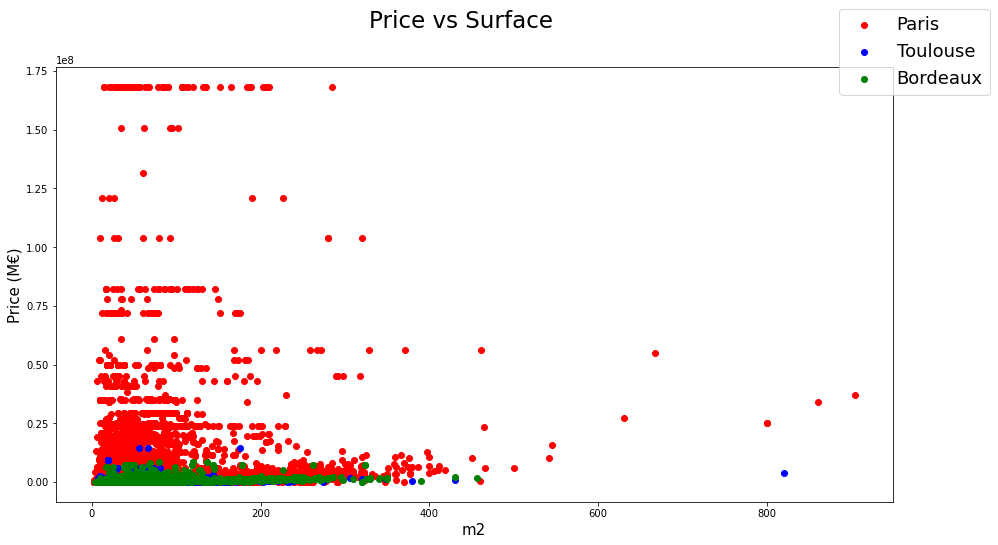

In [20]:
#Plot price vs surface for the 3 cities
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
for clr,city in zip(('r','b','g'),('Paris','Toulouse','Bordeaux')):
    plt.scatter(x=df_price[df_price['nom_commune']==city]['surface_reelle_bati'],y=df_price[df_price['nom_commune']==city]['valeur_fonciere'],color=clr)

plt.suptitle('Price vs Surface',fontsize=23)
plt.figlegend(['Paris','Toulouse','Bordeaux'],loc='upper right',fontsize=18)

plt.xlabel('m2',fontsize=15)
plt.ylabel('Price (M€)',fontsize=15)


Text(0.5, 0.98, 'Price distribution per city')

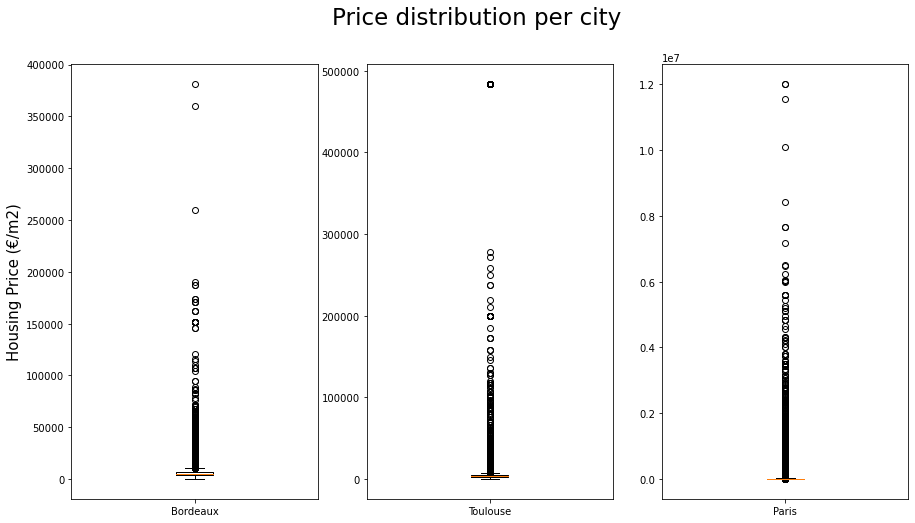

In [21]:
#Obviously there a lot of outliers, so that we can't observe any trend
fig=plt.figure(figsize=(15,8))

ax0=fig.add_subplot(1,3,1)
ax0=plt.boxplot(df_price[df_price['nom_commune']=='Bordeaux']['prix_m2'],labels=['Bordeaux'])
plt.ylabel('Housing Price (€/m2)',fontsize=15)

ax1=fig.add_subplot(1,3,2)
plt.boxplot(df_price[df_price['nom_commune']=='Toulouse']['prix_m2'],labels=['Toulouse'])

ax2=fig.add_subplot(1,3,3)
plt.boxplot(df_price[df_price['nom_commune']=='Paris']['prix_m2'],labels=['Paris'])

plt.suptitle('Price distribution per city',fontsize=23)

In [22]:
#Let's remove outliers - we should have done it earlier when dealing with dataframe for each city

IQRt = df_price[df_price['nom_commune']=='Toulouse']['prix_m2'].quantile(0.75) - df_price[df_price['nom_commune']=='Toulouse']['prix_m2'].quantile(0.25)
q1t = df_price[df_price['nom_commune']=='Toulouse']['prix_m2'].quantile(0.25) - IQRt
q3t = df_price[df_price['nom_commune']=='Toulouse']['prix_m2'].quantile(0.75) + IQRt

IQRb = df_price[df_price['nom_commune']=='Bordeaux']['prix_m2'].quantile(0.75) - df_price[df_price['nom_commune']=='Bordeaux']['prix_m2'].quantile(0.25)
q1b = df_price[df_price['nom_commune']=='Bordeaux']['prix_m2'].quantile(0.25) - IQRb
q3b = df_price[df_price['nom_commune']=='Bordeaux']['prix_m2'].quantile(0.75) + IQRb

IQRp = df_price[df_price['nom_commune']=='Paris']['prix_m2'].quantile(0.75) - df_price[df_price['nom_commune']=='Paris']['prix_m2'].quantile(0.25)
q1p = df_price[df_price['nom_commune']=='Paris']['prix_m2'].quantile(0.25) - IQRp
q3p = df_price[df_price['nom_commune']=='Paris']['prix_m2'].quantile(0.75) + IQRp

df_price=pd.concat([
    df_price[(df_price['nom_commune']=='Paris') & (df_price['prix_m2'] < q3p) & (df_price['prix_m2'] > q1p) ],
    df_price[(df_price['nom_commune']=='Toulouse') & (df_price['prix_m2'] < q3t) & (df_price['prix_m2'] > q1t) ],
    df_price[(df_price['nom_commune']=='Bordeaux') & (df_price['prix_m2'] < q3b) & (df_price['prix_m2'] > q1b) ]],
    axis=0)

df_price.reset_index(inplace =True)

print(df_price.shape[0])
df_price.head()

40435


,index,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement,prix_m2
0,13413,2019-1062991,2019-01-04,1196000.0,75001.0,Paris,Appartement,112.0,3.0,NaN,2.325288,48.868416,1,10678.571429
1,13414,2019-1062992,2019-01-03,1570490.0,75003.0,Paris,Appartement,104.0,3.0,NaN,2.363076,48.860305,3,15100.865385
2,13416,2019-1062995,2019-01-10,230000.0,75003.0,Paris,Appartement,26.0,1.0,NaN,2.354961,48.868615,3,8846.153846
3,13417,2019-1062997,2019-01-05,955750.0,75008.0,Paris,Appartement,80.0,3.0,NaN,2.314393,48.880118,8,11946.875000
4,13418,2019-1062998,2019-01-07,506800.0,75003.0,Paris,Appartement,45.0,2.0,NaN,2.362024,48.865675,3,11262.222222


In [23]:
print(max(df_price[df_price['nom_commune']=='Toulouse']['prix_m2']))

6530.260869565217


Text(0.5, 0.98, 'Price distribution per city')

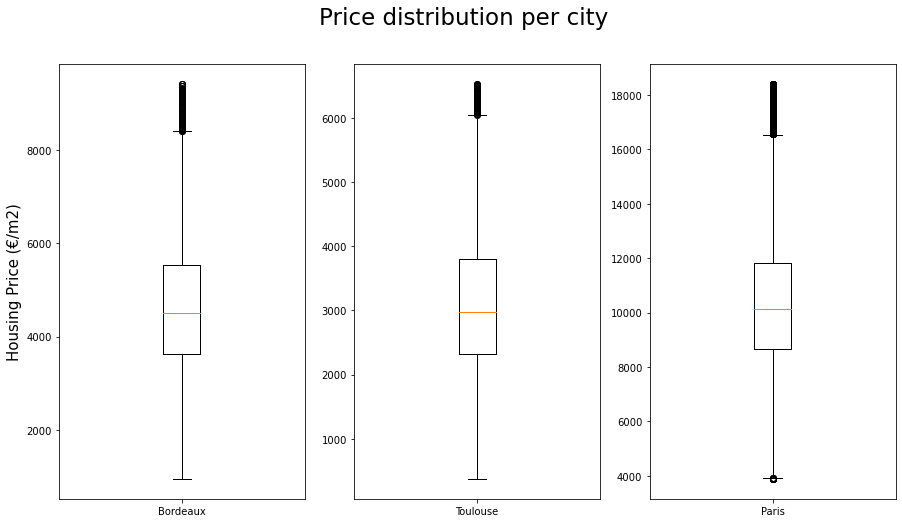

In [24]:
#Let's check the new price distribution per city
fig1=plt.figure(figsize=(15,8))

ax0=fig1.add_subplot(1,3,1)
ax0=plt.boxplot(df_price[df_price['nom_commune']=='Bordeaux']['prix_m2'],labels=['Bordeaux'])
plt.ylabel('Housing Price (€/m2)',fontsize=15)

ax1=fig1.add_subplot(1,3,2)
plt.boxplot(df_price[df_price['nom_commune']=='Toulouse']['prix_m2'],labels=['Toulouse'])

ax2=fig1.add_subplot(1,3,3)
plt.boxplot(df_price[df_price['nom_commune']=='Paris']['prix_m2'],labels=['Paris'])

plt.suptitle('Price distribution per city',fontsize=23)

([<matplotlib.axis.XTick at 0x7ff0cc5cf438>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

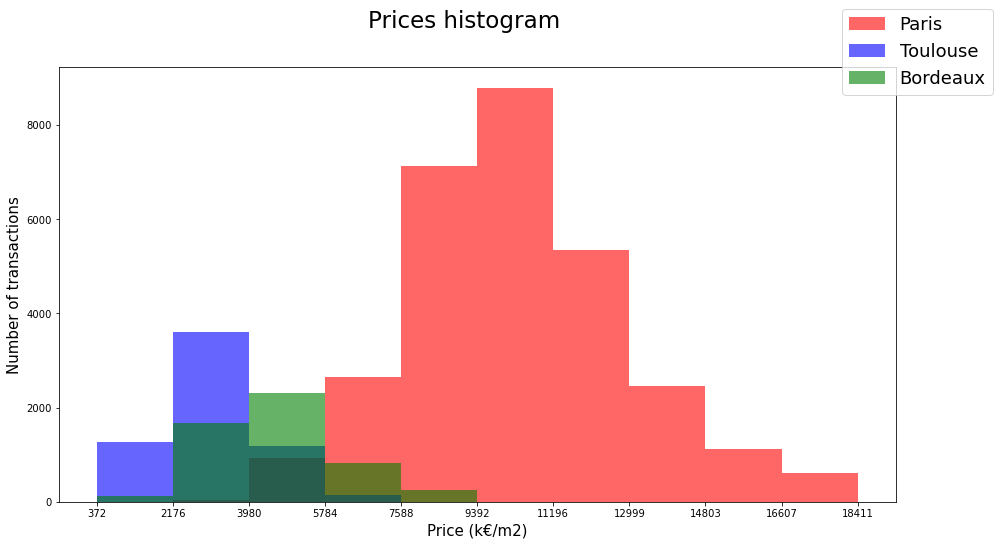

In [25]:
#Plot price/m2 histogram for each city
count, bin_edges =np.histogram(df_price['prix_m2'])

plt.figure(figsize=(15,8))
for clr,city in zip(('r','b','g'),('Paris','Toulouse','Bordeaux')):
    plt.hist(df_price[df_price['nom_commune']==city]['prix_m2'],bins=bin_edges,color=clr,alpha=0.6)

plt.suptitle('Prices histogram',fontsize=23)
plt.figlegend(['Paris','Toulouse','Bordeaux'],loc='upper right',fontsize=18)
plt.xlabel('Price (k€/m2)',fontsize=15)
plt.ylabel('Number of transactions',fontsize=15)
plt.xticks(bin_edges)

(0.0, 4000000.0)

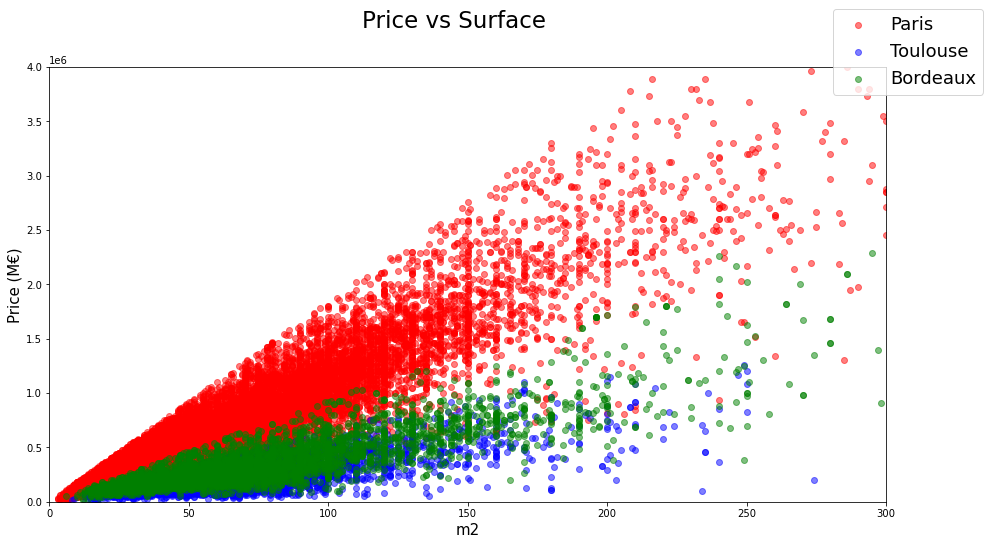

In [26]:
#Plot price vs surface for the 3 cities - Limit surface to 250 m2 & price to 2 000 keuros
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
for clr,city in zip(('r','b','g'),('Paris','Toulouse','Bordeaux')):
    plt.scatter(x=df_price[df_price['nom_commune']==city]['surface_reelle_bati'],y=df_price[df_price['nom_commune']==city]['valeur_fonciere'],color=clr,alpha=0.5)

plt.suptitle('Price vs Surface',fontsize=23)
plt.figlegend(['Paris','Toulouse','Bordeaux'],loc='upper right',fontsize=18)

plt.xlabel('m2',fontsize=15)
plt.ylabel('Price (M€)',fontsize=15)
plt.xlim(0,300)
plt.ylim(0,4000000)


__So we have nown a dataframe with all real transactions for 2019 in Paris, Toulouse and Bordeaux.__

____We can observe the different trends of Price vs m2 for each city.____

__We now need to gather the transaction per neighborhood to get an average price/m2 per neighborhood__

In [27]:
df_quartiers.head()

,Quartier,Latitude,Longitude,City,arrondissement
0,CARMES,43.596087197,1.44140164967,Toulouse,Toulouse
1,AMIDONNIERS,43.6062858201,1.42339702287,Toulouse,Toulouse
2,MINIMES,43.6191621779,1.43195460628,Toulouse,Toulouse
3,BONNEFOY,43.6195659969,1.45452253663,Toulouse,Toulouse
4,MARENGO - JOLIMONT,43.6117583769,1.46190401897,Toulouse,Toulouse


In [28]:
df_price.head()

,index,id_mutation,date_mutation,valeur_fonciere,code_postal,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,arrondissement,prix_m2
0,13413,2019-1062991,2019-01-04,1196000.0,75001.0,Paris,Appartement,112.0,3.0,NaN,2.325288,48.868416,1,10678.571429
1,13414,2019-1062992,2019-01-03,1570490.0,75003.0,Paris,Appartement,104.0,3.0,NaN,2.363076,48.860305,3,15100.865385
2,13416,2019-1062995,2019-01-10,230000.0,75003.0,Paris,Appartement,26.0,1.0,NaN,2.354961,48.868615,3,8846.153846
3,13417,2019-1062997,2019-01-05,955750.0,75008.0,Paris,Appartement,80.0,3.0,NaN,2.314393,48.880118,8,11946.875000
4,13418,2019-1062998,2019-01-07,506800.0,75003.0,Paris,Appartement,45.0,2.0,NaN,2.362024,48.865675,3,11262.222222


In [29]:
df_price.dropna(subset=['longitude','latitude'], axis=0,inplace=True)
df_price.reset_index(inplace =True)


In [30]:
#We calculate the average price/m2 over the transactions located in a radius of 500 m2 around the neighborhood
from statistics import mean
import geopy.distance

for i in np.arange(df_quartiers.shape[0]):
    df_price_i = df_price[df_price['arrondissement']==df_quartiers.loc[i, 'arrondissement']]
    df_price_i.reset_index(inplace=True, drop =True)
    df_price_ij=[]
    for j in np.arange(df_price_i.shape[0]):
        if geopy.distance.distance((df_quartiers.loc[i,'Longitude'],df_quartiers.loc[i,'Latitude']),(df_price_i.loc[j,'longitude'],df_price_i.loc[j,'latitude'])).m <500:
            df_price_ij.append(df_price_i.loc[j,'prix_m2'])
    if (len(df_price_ij)>0):
        df_quartiers.loc[i,'prix_m2']=mean(df_price_ij)
    else:
        df_quartiers.loc[i,'prix_m2']=0
                  

In [31]:
pd.options.display.float_format = '{:.2f}'.format
df_quartiers.head()

,Quartier,Latitude,Longitude,City,arrondissement,prix_m2
0,CARMES,43.596087197,1.44140164967,Toulouse,Toulouse,4624.42
1,AMIDONNIERS,43.6062858201,1.42339702287,Toulouse,Toulouse,3638.38
2,MINIMES,43.6191621779,1.43195460628,Toulouse,Toulouse,3089.11
3,BONNEFOY,43.6195659969,1.45452253663,Toulouse,Toulouse,3078.21
4,MARENGO - JOLIMONT,43.6117583769,1.46190401897,Toulouse,Toulouse,3003.14


## 3. Retrieve venues for all 3 cities from Foursquare API

In [32]:
#Foursquare credentials & version
CLIENT_ID = 'YSOULYBOG15ZML03K0NU5PFM0H5EWABOURXGXKMXMCLT1RJW' # your Foursquare ID
CLIENT_SECRET = 'JFPEPJ5BUXO5MLA5TNK5DZC1Y0AB4HDY2DR0YGJQ00JLTLYB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YSOULYBOG15ZML03K0NU5PFM0H5EWABOURXGXKMXMCLT1RJW
CLIENT_SECRET:JFPEPJ5BUXO5MLA5TNK5DZC1Y0AB4HDY2DR0YGJQ00JLTLYB


In [33]:
#We will use the same function as defined in previous lab about exploring New York
#This function allows to retrieve the venues from Foursquare API for each neighbooroud
LIMIT=100

def getNearbyVenues(cities, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
            
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
#Now we can apply this function to our 3 cities
french_venues = getNearbyVenues(cities=df_quartiers['City'],
                                   names=df_quartiers['Quartier'],
                                   latitudes=df_quartiers['Latitude'],
                                   longitudes=df_quartiers['Longitude']
                                  )
print('Venues loaded')

Venues loaded


In [35]:
#And check the results
print(french_venues.shape)
french_venues.head()

(6354, 8)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Toulouse,CARMES,43.596087197,1.44140164967,London Town,43.60,1.44,Pub
1,Toulouse,CARMES,43.596087197,1.44140164967,La Braisière,43.60,1.44,French Restaurant
2,Toulouse,CARMES,43.596087197,1.44140164967,L'Anartiste,43.60,1.44,Bar
3,Toulouse,CARMES,43.596087197,1.44140164967,L'Annexe,43.60,1.44,Wine Bar
4,Toulouse,CARMES,43.596087197,1.44140164967,Le point d'Ogre,43.60,1.44,French Restaurant


In [36]:
#Let's have a look at the distribution of the number of venues per neighborhood
df_distrib=french_venues.groupby('Neighborhood').count()[['City']]
df_distrib.sort_values('City',axis=0, ascending=True,inplace=True)
df_distrib.reset_index(inplace=True)
df_distrib.rename(columns={'Neighborhood':'Quartier','City':'Venue_count'},inplace=True)
df_distrib.head()


,Quartier,Venue_count
0,ZONES D'ACTIVITES SUD,1
1,Picpus,1
2,ROSERAIE,1
3,LARDENNE,2
4,POUVOURVILLE,2


In [37]:
#Merging with our previous dataframe to be able to analyse those results
df_distrib=df_distrib.merge(df_quartiers, on='Quartier')
df_distrib.head(10)

,Quartier,Venue_count,Latitude,Longitude,City,arrondissement,prix_m2
0,ZONES D'ACTIVITES SUD,1,43.5540170114,1.41678405499,Toulouse,Toulouse,0.00
1,Picpus,1,48.8303592424,2.42882681508,Paris,12,0.00
2,ROSERAIE,1,43.6263301962,1.46844795716,Toulouse,Toulouse,1856.11
3,LARDENNE,2,43.595449714,1.38474942577,Toulouse,Toulouse,3385.04
4,POUVOURVILLE,2,43.5461910801,1.45271875461,Toulouse,Toulouse,2938.43
5,EMPALOT,3,43.5788165728,1.44020779771,Toulouse,Toulouse,2486.29
6,Caudéran,3,44.85,-0.61,Bordeaux,Bordeaux,4011.41
7,BELLEFONTAINE,3,43.5629440283,1.39914514871,Toulouse,Toulouse,916.00
8,FONTAINE-LESTANG,3,43.5843782291,1.41961410897,Toulouse,Toulouse,2261.54
9,GINESTOUS,3,43.644969534,1.41306195552,Toulouse,Toulouse,2702.70


([], [])

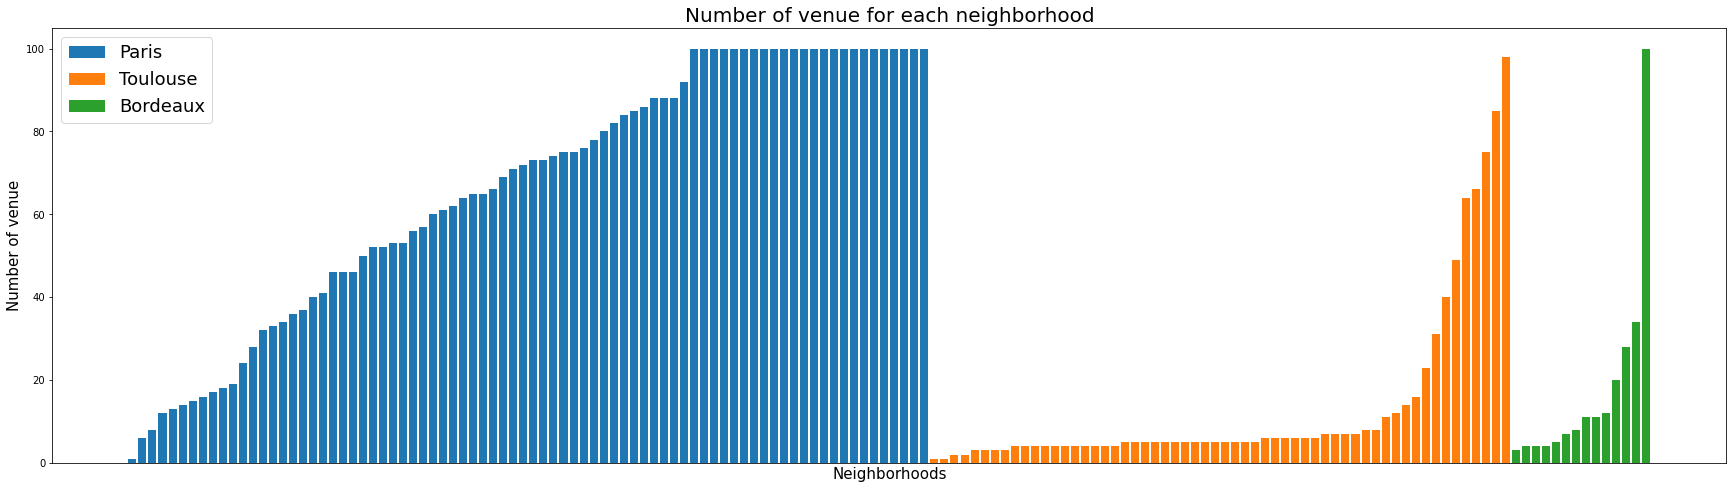

In [38]:
#Plotting the distribution per city
fig=plt.figure(figsize=(30,8))

for clr,city in zip(('r','b','g'),('Paris','Toulouse','Bordeaux')):
    plt.bar(df_distrib[df_distrib['City']==city]['Quartier'], df_distrib[df_distrib['City']==city]['Venue_count'])

plt.xlabel('Neighborhoods',fontsize=15)
plt.ylabel('Number of venue',fontsize=15)
plt.title('Number of venue for each neighborhood',fontsize=20)
plt.legend(('Paris','Toulouse','Bordeaux'),fontsize=18)
plt.xticks([])

Text(0.5, 0.98, 'Number of venue per Neighborhood')

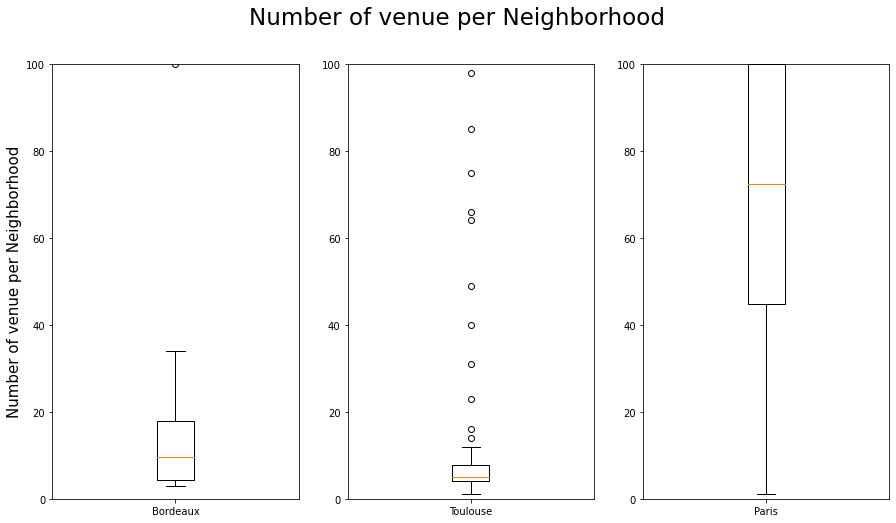

In [39]:
#There are much more venues provided per neighborhood in Paris than in Toulouse or Bordeaux. Let's check the distribution on a boxplot
fig1=plt.figure(figsize=(15,8))

ax0=fig1.add_subplot(1,3,1)
ax0=plt.boxplot(df_distrib[df_distrib['City']=='Bordeaux']['Venue_count'],labels=['Bordeaux'])
plt.ylabel('Number of venue per Neighborhood',fontsize=15)
plt.ylim(0,100)

ax1=fig1.add_subplot(1,3,2)
plt.boxplot(df_distrib[df_distrib['City']=='Toulouse']['Venue_count'],labels=['Toulouse'])
plt.ylim(0,100)

ax2=fig1.add_subplot(1,3,3)
plt.boxplot(df_distrib[df_distrib['City']=='Paris']['Venue_count'],labels=['Paris'])
plt.ylim(0,100)

plt.suptitle('Number of venue per Neighborhood',fontsize=23)

In [40]:
bins = [0, 10, 100]

print(bins)

group_names=['<10', '>10']

df_distrib['count_binned']=pd.cut(df_distrib['Venue_count'],bins,labels=group_names,include_lowest=True)

df_distrib.head()

[0, 10, 100]


,Quartier,Venue_count,Latitude,Longitude,City,arrondissement,prix_m2,count_binned
0,ZONES D'ACTIVITES SUD,1,43.5540170114,1.41678405499,Toulouse,Toulouse,0.00,<10
1,Picpus,1,48.8303592424,2.42882681508,Paris,12,0.00,<10
2,ROSERAIE,1,43.6263301962,1.46844795716,Toulouse,Toulouse,1856.11,<10
3,LARDENNE,2,43.595449714,1.38474942577,Toulouse,Toulouse,3385.04,<10
4,POUVOURVILLE,2,43.5461910801,1.45271875461,Toulouse,Toulouse,2938.43,<10


In [41]:
#Now let's have a look at where are the neighborhood with a small number of values in Bordeaux

address = 'Bordeaux'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Bordeaux using latitude and longitude values
map_bordeaux = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for clr, count in zip(('blue','red'), group_names):
    df_marker=df_distrib[df_distrib['count_binned']==count]
    
    for lat, lng, label in zip(df_marker[df_marker['City']=='Bordeaux']['Latitude'], 
                           df_marker[df_marker['City']=='Bordeaux']['Longitude'], 
                           df_marker[df_marker['City']=='Bordeaux']['Quartier']):
        
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.7,
            parse_html=False).add_to(map_bordeaux)  
    
map_bordeaux


In [42]:
#Now let's have a look at where are the neighborhood with a small number of values in Toulouse
df_distrib['Latitude']=df_distrib['Latitude'].astype('float')
df_distrib['Longitude']=df_distrib['Longitude'].astype('float')

address = 'Toulouse'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toulouse using latitude and longitude values
map_toulouse= folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for clr, count in zip(('blue', 'red'), group_names):
    df_marker=df_distrib[df_distrib['count_binned']==count]
    
    for lat, lng, label in zip(df_marker[df_marker['City']=='Toulouse']['Latitude'], 
                           df_marker[df_marker['City']=='Toulouse']['Longitude'], 
                           df_marker[df_marker['City']=='Toulouse']['Quartier']):
        
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.7,
            parse_html=False).add_to(map_toulouse) 
        
map_toulouse

In [43]:
#Now let's have a look at where are the neighborhood with a small number of values in Paris

address = 'Paris'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toulouse using latitude and longitude values
map_paris= folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for clr, count in zip(('blue','red'), group_names):
    df_marker=df_distrib[df_distrib['count_binned']==count]
    
    for lat, lng, label in zip(df_marker[df_marker['City']=='Paris']['Latitude'], 
                           df_marker[df_marker['City']=='Paris']['Longitude'], 
                           df_marker[df_marker['City']=='Paris']['Quartier']):
        
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.7,
            parse_html=False).add_to(map_paris) 
        
map_paris

It is clear that Neighborhoods with less venues are at the periphery of the cities, which makes sense.
However the proportion of venues actually reported in Foursquare is probably smaller in Bordeaux than in Paris.
Anyway we are going to drop the neighborhoods with less than 10 venues as they can't be compared with others, and living in a neighborhood crouded with venues we do'nt want to move to an isolated neighborhood, far from any commodity.

In [44]:
df_distrib_10 = df_distrib[df_distrib['count_binned']=='>10']
df_distrib_10.drop('count_binned', axis =1, inplace = True)
df_distrib_10.reset_index(drop=True,inplace=True)
df_distrib_10.shape[0]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


97

In [45]:
french_venues=french_venues[french_venues['Neighborhood'].isin(df_distrib_10['Quartier'])]
french_venues.reset_index(inplace=True)
french_venues.shape

(6092, 9)

In [46]:
french_onehot = pd.get_dummies(french_venues['Venue Category'])

print('There are {} different categories'.format(french_onehot.shape[1]))

french_onehot['Neighborhood']=french_venues['Neighborhood']

columns=[french_onehot.columns[-1]]+list(french_onehot.columns[:-1])

french_onehot=french_onehot[columns]

french_onehot.head()




There are 319 different categories


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Basque Restaurant,Bathing Area,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Public Art,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki S

,Number_Venues
Fried Chicken Joint,1.00
Provençal Restaurant,1.00
Gas Station,1.00
General College & University,1.00
Dive Spot,1.00


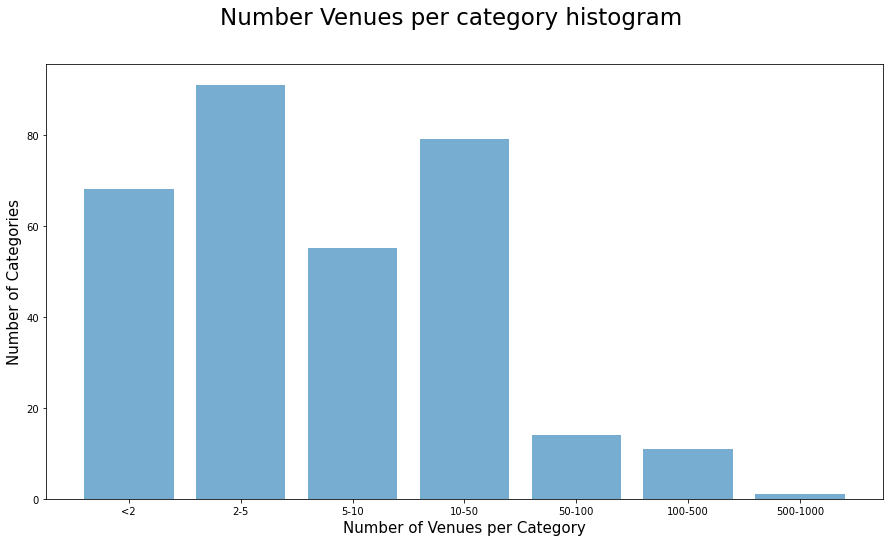

In [47]:
#Let's look at the number of venue per category
french_onehot_sorted = pd.DataFrame(french_onehot.sum())
french_onehot_sorted.drop('Neighborhood', axis=0, inplace = True)
french_onehot_sorted.columns=['Number_Venues']
french_onehot_sorted['Number_Venues']=french_onehot_sorted['Number_Venues'].astype('float')
french_onehot_sorted.sort_values(by='Number_Venues', inplace=True, ascending= False)

bins = [0,2,5,10,50,100,500,1000]

count, bin_edges =np.histogram(french_onehot_sorted['Number_Venues'],bins)

plt.figure(figsize=(15,8))

plt.bar(["<2","2-5","5-10","10-50","50-100","100-500","500-1000"],count,alpha=0.6)

plt.suptitle('Number Venues per category histogram',fontsize=23)
plt.ylabel('Number of Categories',fontsize=15)
plt.xlabel('Number of Venues per Category',fontsize=15)

french_onehot_sorted.tail()


In [48]:
#Some venue categories are too precise, and similar type of venues have different names. 
#Venues with a single occurence can't be used to compare with other neighborhoods.

french_onehot_sorted.tail(50)

,Number_Venues
Track Stadium,1.00
Bowling Alley,1.00
Tibetan Restaurant,1.00
Cemetery,1.00
Tennis Stadium,1.00
Caucasian Restaurant,1.00
Military Base,1.00
Sports Club,1.00
Non-Profit,1.00
Hawaiian Restaurant,1.00


In [49]:
#Many venues types with a single occurence are restaurants. We will group them in bigger categories.
#They will less precise but more usefull when it comes to comparing the neighborhoods.
restaurants=list()

for i in french_onehot.columns:
    if ('Restaurant' in i) or ('Joint' in i):
        restaurants.append(i)

print(len(restaurants))


87


In [50]:
french_onehot[restaurants].sum()

Afghan Restaurant                    1
African Restaurant                  16
Alsatian Restaurant                  1
American Restaurant                 14
Arepa Restaurant                     2
Argentinian Restaurant               8
Asian Restaurant                    45
Auvergne Restaurant                  3
BBQ Joint                            7
Basque Restaurant                    7
Belgian Restaurant                   4
Brazilian Restaurant                 4
Breton Restaurant                    4
Burger Joint                        67
Burgundian Restaurant                2
Cajun / Creole Restaurant            5
Cambodian Restaurant                 5
Cantonese Restaurant                 3
Caribbean Restaurant                 1
Caucasian Restaurant                 1
Ch'ti Restaurant                     1
Chinese Restaurant                  53
Comfort Food Restaurant              1
Corsican Restaurant                  4
Doner Restaurant                     5
Eastern European Restaura

In [51]:
Asian_Restaurant = ['Vietnamese Restaurant','Tibetan Restaurant','Thai Restaurant','Taiwanese Restaurant','Szechuan Restaurant','Sushi Restaurant',
                    'Udon Restaurant','Shanxi Restaurant', 'Ramen Restaurant','Okonomiyaki Restaurant', 'Korean Restaurant', 'Jiangxi Restaurant' , 'Japanese Restaurant',
                   'Indonesian Restaurant', 'Indian Restaurant', 'Afghan Restaurant', 'Asian Restaurant', 'Cambodian Restaurant', 'Cantonese Restaurant', 'Chinese Restaurant',
                    'Poke Place', 'Korean BBQ Restaurant', 'Soba Restaurant']

African_Restaurant = ['Moroccan Restaurant', 'Ethiopian Restaurant', 'African Restaurant']

North_American_Restaurant = ['New American Restaurant', 'Hawaiian Restaurant', 'American Restaurant', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Steakhouse',
                             'Hot Dog Joint', 'Fried Chicken Joint', 'Mac & Cheese Joint', 'BBQ Joint', 'Burger Joint']

European_Restaurant = ['Tapas Restaurant','Syrian Restaurant', 'Spanish Restaurant','Scandinavian Restaurant','Russian Restaurant','Romanian Restaurant','Portuguese Restaurant',
                       'Modern European Restaurant', 'Mediterranean Restaurant', 'Italian Restaurant', 'Greek Restaurant', 'English Restaurant', 'Belgian Restaurant',
                       'Caucasian Restaurant', 'Eastern European Restaurant', 'Trattoria/Osteria' ]

French_Regions_Restaurant =['Southwestern French Restaurant', 'Southern / Soul Food Restaurant','Savoyard Restaurant','Provençal Restaurant', 'Savoyard Restaurant',
                            'Fondue Restaurant', 'Alsatian Restaurant', 'Auvergne Restaurant', 'Basque Restaurant', 'Breton Restaurant', 'Burgundian Restaurant',
                           'Corsican Restaurant', 'Lyonese Bouchon']

South_America_Restaurant = ['Venezuelan Restaurant','South American Restaurant','Peruvian Restaurant','Mexican Restaurant', 'Latin American Restaurant', 'Arepa Restaurant',
                           'Argentinian Restaurant', 'Brazilian Restaurant', 'Empanada Restaurant', 'Taco Place']

Middle_East_Restaurant = ['Turkish Restaurant','Middle Eastern Restaurant', 'Lebanese Restaurant', 'Kebab Restaurant', 'Jewish Restaurant', 'Israeli Restaurant',
                         'Falafel Restaurant', 'Doner Restaurant']

Modern_Food_Restaurant = ['Vegetarian / Vegan Restaurant','Seafood Restaurant','Molecular Gastronomy Restaurant', 'Gluten-free Restaurant', 'Comfort Food Restaurant']

Hotel = ['Hotel', 'Hostel']

In [52]:
french_onehot['Asian_Restaurant'] = french_onehot[Asian_Restaurant].sum(axis=1)
french_onehot['African_Restaurant'] = french_onehot[African_Restaurant].sum(axis=1)
french_onehot['North_American_Restaurant'] = french_onehot[North_American_Restaurant].sum(axis=1)
french_onehot['European_Restaurant'] = french_onehot[European_Restaurant].sum(axis=1)
french_onehot['French_Regions_Restaurant'] = french_onehot[French_Regions_Restaurant].sum(axis=1)
french_onehot['South_America_Restaurant'] = french_onehot[South_America_Restaurant].sum(axis=1)
french_onehot['Middle_East_Restaurant'] = french_onehot[Middle_East_Restaurant].sum(axis=1)
french_onehot['Modern_Food_Restaurant'] = french_onehot[Modern_Food_Restaurant].sum(axis=1)

french_onehot.drop(Asian_Restaurant, axis = 1, inplace=True)
french_onehot.drop(African_Restaurant, axis = 1, inplace=True)
french_onehot.drop(North_American_Restaurant, axis = 1, inplace=True)
french_onehot.drop(European_Restaurant, axis = 1, inplace=True)
french_onehot.drop(French_Regions_Restaurant, axis = 1, inplace=True)
french_onehot.drop(South_America_Restaurant, axis = 1, inplace=True)
french_onehot.drop(Middle_East_Restaurant, axis = 1, inplace=True)
french_onehot.drop(Modern_Food_Restaurant, axis = 1, inplace=True)



In [53]:
french_onehot['Hotel']=french_onehot['Hotel']+french_onehot['Hostel']
french_onehot.drop('Hostel', axis = 1, inplace=True)

In [54]:
print('There are now {} different categories'.format(french_onehot.shape[1]))


There are now 239 different categories


Text(0.5, 0, 'Number of Venues per Category')

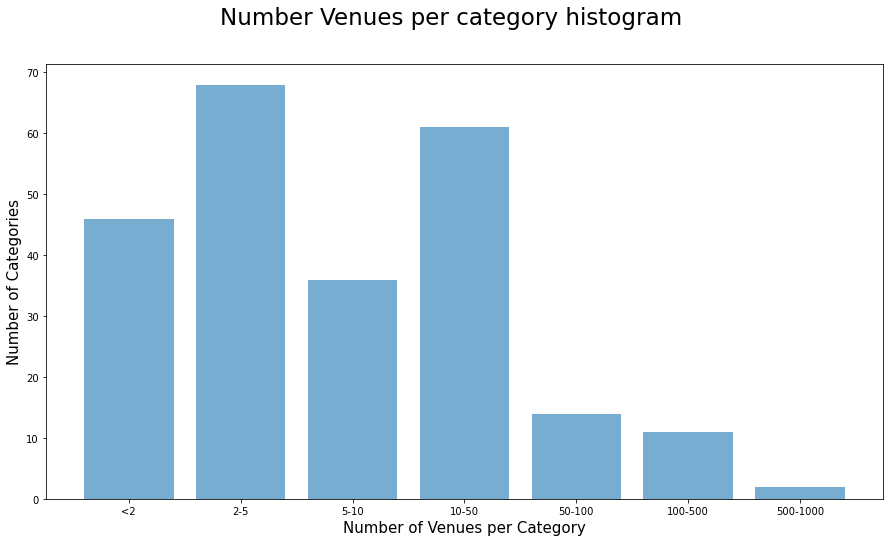

In [55]:
#Let's look at the new distribution of number of venue per category
french_onehot_sorted = pd.DataFrame(french_onehot.sum())
french_onehot_sorted.drop('Neighborhood', axis=0, inplace = True)
french_onehot_sorted.columns=['Number_Venues']
french_onehot_sorted['Number_Venues']=french_onehot_sorted['Number_Venues'].astype('float')
french_onehot_sorted.sort_values(by='Number_Venues', inplace=True, ascending= False)

bins = [0,2,5,10,50,100,500,1000]

count, bin_edges =np.histogram(french_onehot_sorted['Number_Venues'],bins)

plt.figure(figsize=(15,8))

plt.bar(["<2","2-5","5-10","10-50","50-100","100-500","500-1000"],count,alpha=0.6)

plt.suptitle('Number Venues per category histogram',fontsize=23)
plt.ylabel('Number of Categories',fontsize=15)
plt.xlabel('Number of Venues per Category',fontsize=15)


In [56]:
#Now we group venues per neighborhood
french_neighs = french_onehot.groupby('Neighborhood').mean().reset_index()
french_neighs.head()

,Neighborhood,Accessories Store,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Bathing Area,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Camera Store,Canal,Canal Lock,Candy Store,Casino,Cemetery,Ch'ti Restaurant,Cheese Shop,Chocolate Shop,Church,Circus,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dive Spot,Dog Run,Donut Shop,Electronics Store,Escape Room,Exhibit,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Lake,Leather Goods Store,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Memorial Site,Men's Store,Metro Station,Military Base,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pub,Public Art,Racecourse,Record Shop,Rental Car Location,Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvenir Shop,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Street Fair,Student Center,Supermarket,Tailor Shop,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Travel Agency,Video Game Store,Vineyard,Volleyball Court,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Asian_Restaurant,African_Restaurant,North_American_Restaurant,European_Restaurant,French_Regions_Restaurant,South_America_Restaurant,Middle_East_Restaurant,Modern_Food_Restaurant
0,ARNAUD BERNARD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.02,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [57]:
#We will re-use the fonction previously defined to rank & return the most common venues per neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [105]:
#Now using this function we can create a dataframe with the 5 most common venues per neighborhood

num_top_venues=5
columns = ['Neighborhood']

ind = ['st', 'nd', 'rd']

for i in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most common venue'.format(i+1, ind[i]))
    except:
        columns.append('{}{} Most common venue'.format(i+1, 'th'))

french_neighs_sorted=pd.DataFrame(columns = columns)

french_neighs_sorted['Neighborhood'] = french_neighs['Neighborhood']
        
for neigh in np.arange(french_neighs.shape[0]):
        french_neighs_sorted.iloc[neigh,1:] = return_most_common_venues(french_neighs.iloc[neigh,:], num_top_venues)
        
french_neighs_sorted.head()


,Neighborhood,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
0,ARNAUD BERNARD,Cluster,French Restaurant,Bar,Plaza,Café
1,Amérique,Cluster,Plaza,French Restaurant,Supermarket,Pool
2,Archives,Cluster,French Restaurant,Asian_Restaurant,Clothing Store,European_Restaurant
3,Arsenal,French Restaurant,Hotel,European_Restaurant,Modern_Food_Restaurant,Asian_Restaurant
4,Arts-et-Métiers,Cluster,French Restaurant,Asian_Restaurant,Hotel,Wine Bar


## 4. Kmeans Clustering based on venues frequency

In [106]:
# Now we estimate the best k for kmeans clustering
import scipy
from scipy.spatial import distance

french_neighs_cluster = french_neighs.drop('Neighborhood',axis=1)
SSE = []

for k in np.arange(2,12):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=12)
    kmeans.fit(french_neighs_cluster)
    french_neighs['Cluster']=kmeans.labels_
    SSEk=0
    for i in np.arange(french_neighs_cluster.shape[0]):
        SSEk = SSEk + scipy.spatial.distance.euclidean(french_neighs_cluster.iloc[i,:],kmeans.cluster_centers_[french_neighs.iloc[i,-1]])
    SSE.append(SSEk)
    
SSE

[115.35861797648519,
 76.90000675878794,
 50.712433080770026,
 44.948284177318236,
 30.638505100510976,
 23.550960933501443,
 19.16468232335959,
 15.365650054857328,
 14.159040381665877,
 12.88264288389026]

Text(0.5, 1.0, 'kvalue optimisation')

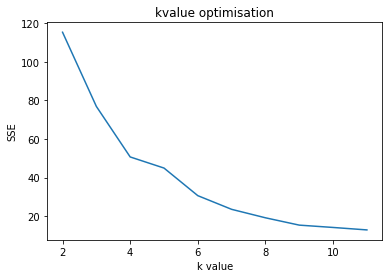

In [107]:
plt.plot(np.arange(2,12),SSE)
plt.xlabel('k value')
plt.ylabel('SSE')
plt.title('kvalue optimisation')

So k=4 is actually the opitmised number of cluster

In [108]:
#Now we will assign the neighborhoods to clusters
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=12)
kmeans.fit(french_neighs_cluster)

print(kmeans.labels_)

[3 0 2 1 1 0 1 3 2 2 3 3 1 3 1 3 1 3 3 1 1 0 2 1 1 2 3 3 0 1 0 2 1 1 1 2 2
 1 1 2 1 2 3 0 3 1 3 2 2 2 1 1 2 1 2 0 2 0 0 1 3 1 0 2 2 1 2 1 2 1 2 1 0 3
 1 3 0 1 3 2 1 2 3 2 1 2 1 1 1 2 1 0 2 1 1 1 0]


In [109]:
#And now we get our final dataframe including: neighborhood, price of housing, cluster & most common venues
columns_result = [french_neighs_sorted.columns[0]] + list(df_quartiers.columns) + list(french_neighs_sorted.columns[1:])

df_quartiers_clustered=french_neighs_sorted.merge(df_quartiers, left_on = 'Neighborhood', right_on='Quartier', how= 'inner')
df_quartiers_clustered=df_quartiers_clustered[columns_result]
df_quartiers_clustered.drop(['Quartier'], axis = 1, inplace = True)
df_quartiers_clustered['Cluster']=kmeans.labels_

df_quartiers_clustered.set_index('Neighborhood', inplace=True)

df_quartiers_clustered.head()

,Latitude,Longitude,City,arrondissement,prix_m2,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,Cluster
Neighborhood,,,,,,,,,,,
ARNAUD BERNARD,43.607587822,1.43979368004,Toulouse,Toulouse,3997.29,Cluster,French Restaurant,Bar,Plaza,Café,3
Amérique,48.8816381673,2.39544016662,Paris,19,0.00,Cluster,Plaza,French Restaurant,Supermarket,Pool,0
Archives,48.8591924127,2.36320505733,Paris,3,0.00,Cluster,French Restaurant,Asian_Restaurant,Clothing Store,European_Restaurant,2
Arsenal,48.851585175,2.36476795387,Paris,4,0.00,French Restaurant,Hotel,European_Restaurant,Modern_Food_Restaurant,Asian_Restaurant,1
Arts-et-Métiers,48.8664702895,2.35708313106,Paris,3,0.00,Cluster,French Restaurant,Asian_Restaurant,Hotel,Wine Bar,1


In [110]:
df_quartiers_clustered['Cluster']=df_quartiers_clustered['Cluster'].astype('int')

In [111]:
#### Now let's have a look at how are the clusters distributed in Paris for example
df_quartiers_clustered['Latitude']=df_quartiers_clustered['Latitude'].astype('float')
df_quartiers_clustered['Longitude']=df_quartiers_clustered['Longitude'].astype('float')

address = 'Paris'

geolocator = Nominatim(user_agent="fr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Paris using latitude and longitude values
map_paris_cluster= folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for clr, clus in zip(('blue','red','green','yellow'), (0,1,2,3)):
    df_clus_plot=df_quartiers_clustered[df_quartiers_clustered['Cluster']==clus]
    
    for lat, lng, label in zip(df_clus_plot[df_clus_plot['City']=='Paris']['Latitude'], 
                           df_clus_plot[df_clus_plot['City']=='Paris']['Longitude'], 
                           df_clus_plot[df_clus_plot['City']=='Paris'].index):
        
        label = folium.Popup(label, parse_html=True)
        
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=clr,
            fill=True,
            fill_color=clr,
            fill_opacity=0.7,
            parse_html=False).add_to(map_paris_cluster) 
        
map_paris_cluster

___Now we have our final dataframe, we can use it to propose new neighborhoods to people wishing to move.
Let's have  look for example at someone currently living in the 'Epinettes'. 
What are the neighborhoods from Paris, Toulouse or Bordeaux with a similar way of life, and what are the real estate prices?___

In [112]:
result = df_quartiers_clustered[df_quartiers_clustered['Cluster']==df_quartiers_clustered.loc['Epinettes', 'Cluster']]
result.sort_values(by='prix_m2', axis=0, ascending=False, inplace=True)
result

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,City,arrondissement,prix_m2,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,Cluster
Neighborhood,,,,,,,,,,,
Saint Jean - Belcier,44.83,-0.56,Bordeaux,Bordeaux,4577.33,Cluster,Hotel,Nightclub,Supermarket,Asian_Restaurant,1
SAINT-GEORGES,43.60,1.45,Toulouse,Toulouse,4515.94,French Restaurant,Plaza,Hotel,Bar,Asian_Restaurant,1
MATABIAU,43.61,1.45,Toulouse,Toulouse,4380.18,Cluster,Hotel,French Restaurant,Bar,Asian_Restaurant,1
SAINT-AUBIN - DUPUY,43.60,1.45,Toulouse,Toulouse,4173.31,French Restaurant,Hotel,Bar,European_Restaurant,North_American_Restaurant,1
COMPANS,43.61,1.43,Toulouse,Toulouse,3741.14,French Restaurant,Hotel,Sandwich Place,Bar,Pizza Place,1
Arsenal,48.85,2.36,Paris,4,0.00,French Restaurant,Hotel,European_Restaurant,Modern_Food_Restaurant,Asian_Restaurant,1
Plaine de Monceaux,48.89,2.30,Paris,17,0.00,Cluster,French Restaurant,European_Restaurant,Hotel,Bakery,1
Porte-Saint-Denis,48.87,2.35,Paris,10,0.00,Cluster,Asian_Restaurant,Hotel,French Restaurant,Bakery,1
Père-Lachaise,48.86,2.40,Paris,20,0.00,Cluster,Asian_Restaurant,Bar,Bakery,Bistro,1


In [113]:
#Sensibility: what if we use k=6 instead of 4?
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=15)
kmeans.fit(french_neighs_cluster)

print(kmeans.labels_)

[3 1 2 5 0 4 5 3 2 2 3 3 5 3 5 3 0 3 3 5 0 4 2 0 5 2 3 3 1 0 1 2 5 0 5 2 2
 5 5 2 5 2 3 1 3 0 3 2 2 2 0 0 2 5 2 1 2 1 1 0 3 0 4 2 2 0 2 0 2 5 2 5 1 3
 5 3 1 0 3 2 0 2 3 2 5 2 5 5 0 2 5 1 2 5 0 0 1]


In [114]:
#And now we get our final dataframe including: neighborhood, price of housing, cluster & most common venues
df_quartiers_clustered['Cluster6']=kmeans.labels_

df_quartiers_clustered.head()

,Latitude,Longitude,City,arrondissement,prix_m2,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,Cluster,Cluster6
Neighborhood,,,,,,,,,,,,
ARNAUD BERNARD,43.61,1.44,Toulouse,Toulouse,3997.29,Cluster,French Restaurant,Bar,Plaza,Café,3,3
Amérique,48.88,2.40,Paris,19,0.00,Cluster,Plaza,French Restaurant,Supermarket,Pool,0,1
Archives,48.86,2.36,Paris,3,0.00,Cluster,French Restaurant,Asian_Restaurant,Clothing Store,European_Restaurant,2,2
Arsenal,48.85,2.36,Paris,4,0.00,French Restaurant,Hotel,European_Restaurant,Modern_Food_Restaurant,Asian_Restaurant,1,5
Arts-et-Métiers,48.87,2.36,Paris,3,0.00,Cluster,French Restaurant,Asian_Restaurant,Hotel,Wine Bar,1,0


In [115]:
result = df_quartiers_clustered[df_quartiers_clustered['Cluster6']==df_quartiers_clustered.loc['Epinettes', 'Cluster6']]
result.sort_values(by='prix_m2', axis=0, ascending=False, inplace=True)
result

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,City,arrondissement,prix_m2,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue,Cluster,Cluster6
Neighborhood,,,,,,,,,,,,
Saint Jean - Belcier,44.83,-0.56,Bordeaux,Bordeaux,4577.33,Cluster,Hotel,Nightclub,Supermarket,Asian_Restaurant,1,0
MATABIAU,43.61,1.45,Toulouse,Toulouse,4380.18,Cluster,Hotel,French Restaurant,Bar,Asian_Restaurant,1,0
Arts-et-Métiers,48.87,2.36,Paris,3,0.00,Cluster,French Restaurant,Asian_Restaurant,Hotel,Wine Bar,1,0
Plaine de Monceaux,48.89,2.30,Paris,17,0.00,Cluster,French Restaurant,European_Restaurant,Hotel,Bakery,1,0
Val-de-Grâce,48.84,2.34,Paris,5,0.00,Cluster,Asian_Restaurant,French Restaurant,Bar,Hotel,1,0
Saint-Vincent-de-Paul,48.88,2.36,Paris,10,0.00,Cluster,Asian_Restaurant,French Restaurant,Hotel,African_Restaurant,1,0
Saint-Georges,48.88,2.33,Paris,9,0.00,Cluster,Hotel,French Restaurant,European_Restaurant,Asian_Restaurant,1,0
Père-Lachaise,48.86,2.40,Paris,20,0.00,Cluster,Asian_Restaurant,Bar,Bakery,Bistro,1,0
Porte-Saint-Denis,48.87,2.35,Paris,10,0.00,Cluster,Asian_Restaurant,Hotel,French Restaurant,Bakery,1,0
